# CAML-PAD

### Input Type: Bro_Logs

##### Import Statements

In [1]:
print("INSTALLED LIBRARIES")
print("*************************")

import pandas as pd
print('Pandas: {:s}'.format(pd.__version__))
import numpy as np
print('Numpy: {:s}'.format(np.__version__))
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
print('Scikit Learn Version:', sklearn.__version__)
import matplotlib.pyplot as plt
# print('MatplotLib Version:', matplotlib.__version__)
import os
import math
import datetime
import pyod

INSTALLED LIBRARIES
*************************
Pandas: 0.24.2
Numpy: 1.16.2
Scikit Learn Version: 0.20.3


##### ElasticSearch Database Connection Established

In [2]:
from elasticsearch import Elasticsearch

print("ELASTICSEARCH INFORMATION")
print("*************************")

print("Connecting to {host} on port {port}...".format(host='172.16.8.70', port='9200'))

es = Elasticsearch([{'host': '{host}', 'port': {port}}])

if es.ping():
    print(" \nCONNECTION: Established")
else:
    print("\nCONNECTION: Failed")

ELASTICSEARCH INFORMATION
*************************
Connecting to 172.16.8.70 on port 9200...
 
CONNECTION: Established


##### Importing Bro Logs as Dataframe

In [3]:
today = str(datetime.datetime.today())
yrIndex = today.find('-')

year = today[:yrIndex]

monthIndex = today[yrIndex+1:].find('-')

month = today[yrIndex+1:][:monthIndex]

dayIndex = today[yrIndex+1:][monthIndex+1:].find(' ')
day = today[yrIndex+1:][monthIndex+1:][:dayIndex]

this_tens, this_ones = divmod(int(day), 10)
this_month = int(month)

print("CURRENT DATE")
print("************")

print("Year: {year}\nMonth: {month}\nDay: {day}".format(year=year, month=month, day=day))

CURRENT DATE
************
Year: 2019
Month: 07
Day: 22


In [4]:
size = 5000
init_month = 6
init_tenths = 2
init_ones = 1
hasModified = False



extraDayL = [1,3,5,7,8,10,12]

extraDay = False if int(this_month) in extraDayL else True

    
if init_month < 10:
    print_init_month = "0{month}".format(month=init_month)
else:
    print_init_month = init_month

    
if this_ones == 1 and this_tens == 0:
    iter_month = this_month - 1
    iter_tens = 3
    iter_ones = 1 if extraDay else 0
    hasModified = True
else:
    iter_month = this_month

if this_ones == 0 and (not hasModified):
    iter_tens = this_tens - 1
    iter_ones = 9
    hasModified = True
elif hasModified:
    a = 1
else:
    iter_tens = this_tens
    
if not hasModified:
    iter_ones = this_ones - 1
    
if iter_month < 10:
    print_month = "0{month}".format(month=iter_month)
else:
    print_month = iter_month



print("TRAINING INFO")
print("*************")

print("Importing Bro Logs of size {size} from {initMonth}/{initTenths}{initOnes} to {Month}/{Tenths}{Ones}..."
      .format(size=size, initMonth=print_init_month, initTenths=init_tenths, initOnes=init_ones, 
              Month=print_month, Tenths=iter_tens, Ones=iter_ones))   


TRAINING INFO
*************
Importing Bro Logs of size 5000 from 06/21 to 07/21...


In [5]:
def findData(month, tens, ones):
    try:
        res = es.search(
            index='bro_index_2019.{month}.{tenDay}{day}'.format(month=month, tenDay=tens, day=ones), 
            body={"query": {"match_all": {}}, "size": size})
    except:
        return "ERROR"
    # print(res['hits']['hits'])

    ids = [d['_id'] for d in res['hits']['hits']]

    mylist = []
    index = []


#     print(list(res['hits']['hits'][0].get('_source').values()))


    for x in range(size):
        sourceD = res['hits']['hits'][x].get('_source')

        for key, value in sourceD.items():
            xx = any(c.isalpha() for c in str(value))

            if not xx:
                try:
                    newstr = float(value)
                except:
                    newstr = value
            else:
                newstr = value

            sourceD[key] = newstr


        mylist.append(sourceD)
        index.append(x + listNum)


    bro_dfX = pd.DataFrame(mylist, index=index)
    return bro_dfX

In [6]:
listNum = 0
init_ten_day = init_tenths
final_ten_day = 3

init_one_day = init_ones
final_one_day = 9

bro_dfL = []

finalMonth = False

init = True
errInit = True

err = []

print("DATA METRICS")
print("************")
print("DAYS COMPLETED:", end = " ")

for aMonth in range(init_month, iter_month+1):
    
    if aMonth < 10:
        input_month = "0{}".format(aMonth)
    else:
        input_month = aMonth
    
    finalMonth = aMonth == iter_month
    final_ten_day = iter_tens if finalMonth else 3
    
    for tenDay in range(init_ten_day, final_ten_day + 1):
        
        if not init:
            init_one_day = 0 if tenDay != 0 else 1
        
        finalTens = tenDay == iter_tens
        final_one_day = iter_ones if finalTens else 9
        
        for oneDay in range(init_one_day, final_one_day + 1):
            
            anExtraDay = True if int(aMonth) in extraDayL else False
            day_break = False
            
            bro_dfI = findData(input_month, tenDay, oneDay)
            
            thisDay = "{}/{}{},".format(input_month, tenDay, oneDay)
            
            if not isinstance(bro_dfI, str):
                bro_dfL.append(bro_dfI)
                print(thisDay, end =" ")  
            else:
               err.append(thisDay)
            
            if tenDay == 3:
                if anExtraDay:
                    if oneDay == 1:
                        break
                else:
                    if oneDay == 0:
                        break
  
            init = False
        
        
    init_ten_day = 0

print("\nERROR:", end=" ")
for day in err:
    print(day, end =" ") 
bro_df = pd.concat(bro_dfL, sort = True)
bro_df.head()

DATA METRICS
************
DAYS COMPLETED: 06/21, 

GET /bro_index_2019.07.01/_search [status:404 request:0.002s]


06/30, 07/02, 07/03, 07/04, 

GET /bro_index_2019.07.06/_search [status:404 request:0.002s]
GET /bro_index_2019.07.07/_search [status:404 request:0.001s]


07/05, 07/08, 07/09, 07/10, 07/11, 07/12, 07/13, 07/14, 07/15, 07/16, 07/17, 07/18, 07/19, 07/20, 07/21, 
ERROR: 07/01, 07/06, 07/07, 

,AA,RA,RD,TC,TTLs,Z,adapter:geoadapter:begin:ts,adapter:geoadapter:end:ts,adapter:hostfromjsonlistadapter:begin:ts,adapter:hostfromjsonlistadapter:end:ts,...,status_msg,tags,timestamp,trans_depth,trans_id,tunnel_parents,uid,uri,user_agent,version
0,False,False,False,False,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.561144e+12,NaN,39176.0,NaN,CTzrlI18YKQ8PsUWH,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.561144e+12,NaN,NaN,[],CSPB7M23X9KJ4L6Rh4,NaN,NaN,NaN
2,False,False,False,False,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.561144e+12,NaN,30950.0,NaN,CV6xyc2iw5FMyJykfl,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.561144e+12,NaN,NaN,[],CfFlZn2yjw76Dkjom2,NaN,NaN,NaN
4,False,False,True,False,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.561144e+12,NaN,64712.0,NaN,CXmmzP3KRYAVwcrHbf,NaN,NaN,NaN


In [7]:
err = []

if this_month < 10:
    my_month = "0{}".format(this_month)
else:
    my_month = this_month
    
print("TESTING DATA")
print("************")
print("DAYS COMPLETED:", end = " ")    

bro_dfT = findData(my_month, this_tens, this_ones)

thisDay = "{}/{}{}".format(this_month, this_tens, this_ones)

if not isinstance(bro_dfT, str):
    print(thisDay, end =" ")  
    
else:
    print("NO DATA FOR THIS DAY", end= " ")

bro_dfT.head()

TESTING DATA
************
DAYS COMPLETED: 7/22 

,AA,RA,RD,TC,TTLs,Z,answers,bro_timestamp,conn_state,duration,...,status_msg,tags,timestamp,trans_depth,trans_id,tunnel_parents,uid,uri,user_agent,version
0,False,False,False,False,NaN,0.0,NaN,1.563775e+09,NaN,NaN,...,NaN,NaN,1.563775e+12,NaN,47081.0,NaN,CTqaCP3Bp6R7NIl2f4,NaN,NaN,NaN
1,False,False,False,False,NaN,0.0,NaN,1.563775e+09,NaN,NaN,...,NaN,NaN,1.563775e+12,NaN,48325.0,NaN,CTUZeZ35n84WaAc3Hc,NaN,NaN,NaN
2,False,False,True,False,NaN,1.0,NaN,1.563775e+09,NaN,NaN,...,NaN,NaN,1.563775e+12,NaN,40100.0,NaN,CUp8zA2VAHW3go2075,NaN,NaN,NaN
3,False,False,False,False,NaN,0.0,NaN,1.563775e+09,NaN,NaN,...,NaN,NaN,1.563775e+12,NaN,42052.0,NaN,Ce4IdC3j4kq1xEHbug,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.563775e+09,S0,0.410247,...,NaN,NaN,1.563775e+12,NaN,NaN,[],CJYZut4gmbFhmCmpLg,NaN,NaN,NaN


##### Dealing with Categorical Data

In [8]:
from sklearn.preprocessing import LabelEncoder

print("ENCODING TRAINING DATA...")

encs = dict()
data = bro_df.copy()  #.sample(frac=1)
for c in data.columns:
    if data[c].dtype == "object" or data[c].isna().any():
        encs[c] = LabelEncoder()
        data[c] = encs[c].fit_transform(data[c].astype('str'))
        
data.head()

ENCODING TRAINING DATA...


,AA,RA,RD,TC,TTLs,Z,adapter:geoadapter:begin:ts,adapter:geoadapter:end:ts,adapter:hostfromjsonlistadapter:begin:ts,adapter:hostfromjsonlistadapter:end:ts,...,status_msg,tags,timestamp,trans_depth,trans_id,tunnel_parents,uid,uri,user_agent,version
0,0,0,0,0,4145,0,2,2,2,2,...,14,1,1.561144e+12,307,11614,1,23858,497,62,2
1,2,2,2,1,4145,2,2,2,2,2,...,14,1,1.561144e+12,307,27608,0,22591,497,62,2
2,0,0,0,0,4145,0,2,2,2,2,...,14,1,1.561144e+12,307,7012,1,24736,497,62,2
3,2,2,2,1,4145,2,2,2,2,2,...,14,1,1.561144e+12,307,27608,0,32668,497,62,2
4,0,0,1,0,4145,1,2,2,2,2,...,14,1,1.561144e+12,307,26064,1,26802,497,62,2


In [9]:
from sklearn.preprocessing import LabelEncoder

print("ENCODING TESTING DATA...")

encsT = dict()
dataT = bro_dfT.copy()  #.sample(frac=1)
for cT in dataT.columns:
    if dataT[cT].dtype == "object" or data[c].isna().any():
        encsT[cT] = LabelEncoder()
        dataT[cT] = encsT[cT].fit_transform(dataT[cT].astype('str'))
        
dataT.head()

ENCODING TESTING DATA...


,AA,RA,RD,TC,TTLs,Z,answers,bro_timestamp,conn_state,duration,...,status_msg,tags,timestamp,trans_depth,trans_id,tunnel_parents,uid,uri,user_agent,version
0,0,0,0,0,181,0.0,149,1.563775e+09,7,NaN,...,3,1,1.563775e+12,NaN,47081.0,1,755,24,5,NaN
1,0,0,0,0,181,0.0,149,1.563775e+09,7,NaN,...,3,1,1.563775e+12,NaN,48325.0,1,737,24,5,NaN
2,0,0,1,0,181,1.0,149,1.563775e+09,7,NaN,...,3,1,1.563775e+12,NaN,40100.0,1,781,24,5,NaN
3,0,0,0,0,181,0.0,149,1.563775e+09,7,NaN,...,3,1,1.563775e+12,NaN,42052.0,1,1025,24,5,NaN
4,2,2,2,1,181,NaN,149,1.563775e+09,3,0.410247,...,3,1,1.563775e+12,NaN,NaN,0,497,24,5,NaN


##### Splitting Encoded Data by Protocol

In [10]:
dns_df = data[bro_df['protocol'] == 'dns']
conn_df = data[bro_df['protocol'] == 'conn']
http_df = data[bro_df['protocol'] == 'http']

dns_dfT = dataT[bro_dfT['protocol'] == 'dns']
conn_dfT = dataT[bro_dfT['protocol'] == 'conn']
http_dfT = dataT[bro_dfT['protocol'] == 'http']

dns_plot_values = []
dns_plotT_values = []
conn_plot_values = []
conn_plotT_values = []
http_plot_values = []
http_plotT_values = []

##### Reformatting DNS Data

In [19]:
dns_cols = list(dns_df.columns)
droppedList = []


print("TRAINING DATA")
print("************")
print("COLUMNS CHECKED:", end = " ") 

for column in dns_cols:
    if dns_df[column].isna().all():
        droppedList.append(column)
    else:
        if list(dns_df[column].isna())[0]:
            dns_df.loc[:,column].fillna(method='bfill', inplace=True)
        else:
            dns_df.loc[:,column].fillna(method='pad', inplace=True)
        print(column + ",", end = " ")

dns_df.drop(droppedList, axis=1, inplace= True)
dns_df.head()

TRAINING DATA
************
COLUMNS CHECKED: AA, RA, RD, TC, TTLs, Z, answers, bro_timestamp, conn_state, guid, history, host, ip_dst_addr, ip_dst_port, ip_src_addr, ip_src_port, local_orig, local_resp, method, original_string, proto, protocol, qclass, qclass_name, qtype, qtype_name, query, rcode, rcode_name, rejected, resp_fuids, resp_mime_types, rtt, service, source:type, status_msg, tags, timestamp, trans_id, tunnel_parents, uid, uri, user_agent, 

,AA,RA,RD,TC,TTLs,Z,answers,bro_timestamp,conn_state,guid,...,service,source:type,status_msg,tags,timestamp,trans_id,tunnel_parents,uid,uri,user_agent
0,0,0,0,0,4145,0,3438,1.561144e+09,13,51948,...,5,0,14,1,1.561144e+12,11614,1,23858,497,62
2,0,0,0,0,4145,0,3438,1.561144e+09,13,84440,...,5,0,14,1,1.561144e+12,7012,1,24736,497,62
4,0,0,1,0,4145,1,3438,1.561144e+09,13,26247,...,5,0,14,1,1.561144e+12,26064,1,26802,497,62
5,0,0,1,0,4145,1,3438,1.561144e+09,13,45186,...,5,0,14,1,1.561144e+12,26066,1,26802,497,62
7,0,0,0,0,4145,0,3438,1.561144e+09,13,16290,...,5,0,14,1,1.561144e+12,9983,1,28773,497,62


In [20]:
dns_colsT = list(dns_dfT.columns)
droppedListT = []

print("TESTING DATA")
print("************")
print("COLUMNS CHECKED:", end = " ") 

for columnT in dns_colsT:
    if dns_dfT[columnT].isna().all():
        droppedListT.append(columnT)
    else:
        if list(dns_dfT[columnT].isna())[0]:
            dns_dfT.loc[:,columnT].fillna(method='bfill', inplace=True)
        else:
            dns_dfT.loc[:,columnT].fillna(method='pad', inplace=True)
        print(columnT + ",", end = " ")
        

dns_dfT.drop(droppedListT, axis=1, inplace=True)
dns_dfT.head()

TESTING DATA
************
COLUMNS CHECKED: AA, RA, RD, TC, TTLs, Z, answers, bro_timestamp, conn_state, guid, history, host, ip_dst_addr, ip_dst_port, ip_src_addr, ip_src_port, local_orig, local_resp, method, original_string, proto, protocol, qclass, qclass_name, qtype, qtype_name, query, rcode, rcode_name, rejected, resp_fuids, resp_mime_types, rtt, service, source:type, status_msg, tags, timestamp, trans_id, tunnel_parents, uid, uri, user_agent, 

,AA,RA,RD,TC,TTLs,Z,answers,bro_timestamp,conn_state,guid,...,service,source:type,status_msg,tags,timestamp,trans_id,tunnel_parents,uid,uri,user_agent
0,0,0,0,0,181,0.0,149,1.563775e+09,7,719,...,3,0,3,1,1.563775e+12,47081.0,1,755,24,5
1,0,0,0,0,181,0.0,149,1.563775e+09,7,1680,...,3,0,3,1,1.563775e+12,48325.0,1,737,24,5
2,0,0,1,0,181,1.0,149,1.563775e+09,7,685,...,3,0,3,1,1.563775e+12,40100.0,1,781,24,5
3,0,0,0,0,181,0.0,149,1.563775e+09,7,3687,...,3,0,3,1,1.563775e+12,42052.0,1,1025,24,5
6,0,0,1,0,181,1.0,149,1.563775e+09,7,4520,...,3,0,3,1,1.563775e+12,40102.0,1,781,24,5


In [21]:
dns_cols = list(dns_df.columns)
dns_colsT = list(dns_dfT.columns)
toDrop = []
toDropT = []

for column in dns_cols:
    if column not in dns_colsT:
        toDrop.append(column)

for columnT in dns_colsT:
    if columnT not in dns_cols:
        toDropT.append(columnT)
print(toDrop)

dns_df.drop(toDrop, axis=1, inplace=True)
dns_dfT.drop(toDropT, axis=1, inplace=True)      

[]


##### Creating Isolation Forest Model

In [66]:
from sklearn.model_selection import train_test_split
dns_train, dns_valid = train_test_split(dns_df, test_size = 0.35)

In [67]:
from pyod.models.iforest import IForest
dns_iforest = IForest(n_estimators = 5, max_samples = 48086, contamination=0.3, behaviour="new")
dns_iforest.fit(dns_train)

C:\Users\Intern Laptop\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:250: UserWarning: max_samples (48086) is greater than the total number of samples (38543). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


IForest(behaviour='new', bootstrap=False, contamination=0.3, max_features=1.0,
    max_samples=48086, n_estimators=5, n_jobs=1, random_state=None,
    verbose=0)

In [190]:
dns_iforest_pred_train = dns_iforest.predict(dns_valid)
dns_iforest_pred_test = dns_iforest.predict(dns_dfT)

# for element in dns_iforest_pred_test:
#     print(element)

print("Accuracy:", list(dns_iforest_pred_train).count(0)/dns_iforest_pred_train.shape[0])


dns_iforest_plot_values = dns_iforest.decision_function(dns_valid)
dns_iforest_plotT_values = dns_iforest.decision_function(dns_dfT)

dns_plot_values.append(abs(dns_iforest_plot_values))
dns_plotT_values.append(abs(dns_iforest_plotT_values))

Accuracy: 0.6897465548809868


##### Visualizing Isolation Forest Model

In [69]:
dns_iforest_pca = PCA(n_components=2).fit_transform(dns_valid)
dns_iforest_pcaT = PCA(n_components=2).fit_transform(dns_dfT)

dns_iforest_plot_df = pd.DataFrame()
dns_iforest_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
dns_iforest_plot_df['x'] = dns_iforest_pca[:, 0] # PCA X Column
dns_iforest_plot_df['y'] = dns_iforest_pca[:, 1] # PCA Y Column
dns_iforest_plot_df['value'] = dns_iforest_plot_values
dns_iforest_plot_df['train'] = 0


dns_iforest_plot_dfT['x'] = dns_iforest_pcaT[:, 0] # PCA X Column
dns_iforest_plot_dfT['y'] = dns_iforest_pcaT[:, 1] # PCA Y Column
dns_iforest_plot_dfT['value'] = dns_iforest_plotT_values
dns_iforest_plot_dfT['train'] = 1

dns_iforest_plot = pd.concat([dns_iforest_plot_df, dns_iforest_plot_dfT])

dns_iforest_plot.head()

,x,y,value,train
0,-6.946087e+08,26612.673503,-0.067798,0
1,-1.214700e+08,-29102.230806,-0.053182,0
2,-1.230028e+08,10508.042641,-0.009852,0
3,-6.960634e+08,-32939.774951,-0.034497,0
4,-2.620333e+08,-32396.835485,-0.063288,0


In [70]:
# Helper method for scatter/beeswarm plot
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

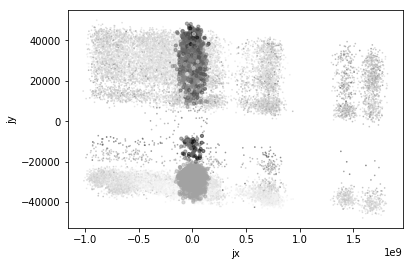

In [71]:
%matplotlib inline
dns_iforest_plot['jx'] = jitter(dns_iforest_plot['x'])
dns_iforest_plot['jy'] = jitter(dns_iforest_plot['y'])
# Now use dataframe group by cluster
iforest_cluster_groups = dns_iforest_plot.groupby('train')
# Plot the Machine Learning results
iforest_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in iforest_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=iforest_size[key], 
               color=dns_iforest_plot[dns_iforest_plot['train'] == key]['value'])

##### Creating CBLOF Model

In [72]:
from pyod.models.cblof import CBLOF
dns_cblof = CBLOF(contamination=0.3)
dns_cblof.fit(dns_train)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.3, n_clusters=8, n_jobs=1, random_state=None,
   use_weights=False)

In [73]:
dns_cblof_pred_train = dns_cblof.predict(dns_valid)
dns_cblof_pred_test = dns_cblof.predict(dns_dfT)

dns_cblof_plot_values = dns_cblof.decision_function(dns_valid)
dns_cblof_plotT_values = dns_cblof.decision_function(dns_dfT)

dns_plot_values.append(dns_cblof_plot_values / 100000000)
dns_plotT_values.append(dns_cblof_plotT_values / 100000000)

##### Visualizing CBLOF Forest Model

In [74]:
dns_cblof_pca = PCA(n_components=2).fit_transform(dns_valid)
dns_cblof_pcaT = PCA(n_components=2).fit_transform(dns_dfT)

dns_cblof_plot_df = pd.DataFrame()
dns_cblof_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
dns_cblof_plot_df['x'] = dns_cblof_pca[:, 0] # PCA X Column
dns_cblof_plot_df['y'] = dns_cblof_pca[:, 1] # PCA Y Column
dns_cblof_plot_df['value'] = dns_cblof_plot_values / 10000000
dns_cblof_plot_df['train'] = 0


dns_cblof_plot_dfT['x'] = dns_cblof_pcaT[:, 0] # PCA X Column
dns_cblof_plot_dfT['y'] = dns_cblof_pcaT[:, 1] # PCA Y Column
dns_cblof_plot_dfT['value'] = dns_cblof_plotT_values / 10000000
dns_cblof_plot_dfT['train'] = 1

dns_cblof_plot = pd.concat([dns_cblof_plot_df, dns_cblof_plot_dfT])

dns_cblof_plot.head()

,x,y,value,train
0,-6.946087e+08,26612.673503,34.713377,0
1,-1.214700e+08,-29102.230806,1.757154,0
2,-1.230028e+08,10508.042641,1.910429,0
3,-6.960634e+08,-32939.774951,34.858850,0
4,-2.620333e+08,-32396.835485,8.544164,0


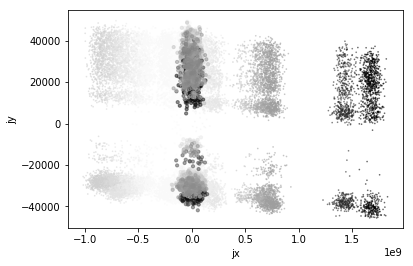

In [75]:
%matplotlib inline
dns_cblof_plot['jx'] = jitter(dns_cblof_plot['x'])
dns_cblof_plot['jy'] = jitter(dns_cblof_plot['y'])
# Now use dataframe group by cluster
cblof_cluster_groups = dns_cblof_plot.groupby('train')
# Plot the Machine Learning results
cblof_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in cblof_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=cblof_size[key], 
               color=dns_cblof_plot[dns_cblof_plot['train'] == key]['value'] * 1000)

##### Creating HBOS Model

In [76]:
from pyod.models.hbos import HBOS
dns_hbos = HBOS(contamination=0.3)
dns_hbos.fit(dns_train)

HBOS(alpha=0.1, contamination=0.3, n_bins=10, tol=0.5)

In [77]:
dns_hbos_pred_train = dns_hbos.predict(dns_valid)
dns_hbos_pred_test = dns_hbos.predict(dns_dfT)

dns_hbos_plot_values = dns_hbos.decision_function(dns_valid)
dns_hbos_plotT_values = dns_hbos.decision_function(dns_dfT)

dns_plot_values.append(dns_hbos_plot_values / 1000)
dns_plotT_values.append(dns_hbos_plotT_values / 1000)

##### Visualizing HBOS Forest Model

In [78]:
dns_hbos_pca = PCA(n_components=2).fit_transform(dns_valid)
dns_hbos_pcaT = PCA(n_components=2).fit_transform(dns_dfT)

dns_hbos_plot_df = pd.DataFrame()
dns_hbos_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
dns_hbos_plot_df['x'] = dns_hbos_pca[:, 0] # PCA X Column
dns_hbos_plot_df['y'] = dns_hbos_pca[:, 1] # PCA Y Column
dns_hbos_plot_df['value'] = dns_hbos_plot_values / 100
dns_hbos_plot_df['train'] = 0


dns_hbos_plot_dfT['x'] = dns_hbos_pcaT[:, 0] # PCA X Column
dns_hbos_plot_dfT['y'] = dns_hbos_pcaT[:, 1] # PCA Y Column
dns_hbos_plot_dfT['value'] = dns_hbos_plotT_values / 100
dns_hbos_plot_dfT['train'] = 1

dns_hbos_plot = pd.concat([dns_hbos_plot_df, dns_hbos_plot_dfT])

dns_hbos_plot.head()

,x,y,value,train
0,-6.946087e+08,26612.673503,0.883404,0
1,-1.214700e+08,-29102.230806,0.892451,0
2,-1.230028e+08,10508.042641,0.955191,0
3,-6.960634e+08,-32939.774951,0.892452,0
4,-2.620333e+08,-32396.835485,0.892451,0


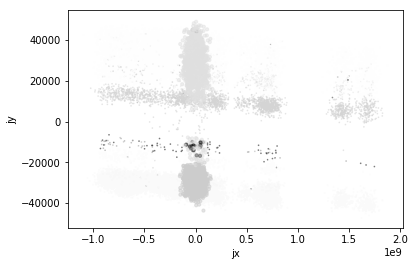

In [79]:
%matplotlib inline
dns_hbos_plot['jx'] = jitter(dns_hbos_plot['x'])
dns_hbos_plot['jy'] = jitter(dns_hbos_plot['y'])
# Now use dataframe group by cluster
hbos_cluster_groups = dns_hbos_plot.groupby('train')
# Plot the Machine Learning results
hbos_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in hbos_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=hbos_size[key], 
               color=dns_hbos_plot[dns_hbos_plot['train'] == key]['value'] * 1000)

##### Combining Models (DEMOCRATIC VOTING)

In [118]:
for x in range(3):
    print(x)

0
1
2


In [204]:
counter = 0
counterT = 0
dns_testVal = []
dns_trainVal = []
prevVal = []

print("COMPILING VOTES")
print("***************")

print("Training Data:", end=" ")
lables = {0: "Isolation Forest", 1:"CBLOF",2:"HBOS" }

for x in range(3):
    print(lables[x], end = ", ")


for value in dns_plot_values:
    
    if counter == 0:
        for aVal in value:
            dns_trainVal.append(aVal)
    else:
        for x in range(value.size):
            oldValue = dns_trainVal[x]
            newValue = oldValue + value[x]
            dns_trainVal[x] = newValue
        
    counter += 1
    
for w in range(len(dns_trainVal)):
    oldVal = dns_trainVal[w]
    newVal = oldVal / counter
    dns_trainVal[w] = newVal
        

print("\nTesting Data:", end=" ")

for valueT in dns_plotT_values:
    
    if counterT == 0:
        for aValT in valueT:
            dns_testVal.append(aValT)
    else:
        for xT in range(valueT.size):
            oldValueT = dns_testVal[xT]
            newValueT = oldValueT + valueT[xT]
            dns_testVal[xT] = newValueT
        
    counterT += 1
    
for wT in range(len(dns_testVal)):
    oldValT = dns_testVal[wT]
    newValT = oldValT / counterT
    dns_testVal[wT] = newValT

    
for x in range(3):
    print(lables[x], end = ", ")


COMPILING VOTES
***************
Training Data: Isolation Forest, CBLOF, HBOS, 
Testing Data: Isolation Forest, CBLOF, HBOS, 

In [205]:
dns_pca = PCA(n_components=2).fit_transform(dns_valid)
dns_pcaT = PCA(n_components=2).fit_transform(dns_dfT)

dns_plot_df = pd.DataFrame()
dns_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
dns_plot_df['x'] = dns_pca[:, 0] # PCA X Column
dns_plot_df['y'] = dns_pca[:, 1] # PCA Y Column
dns_plot_df['value'] = dns_trainVal  
dns_plot_df['train'] = 0

dns_plot_dfT['x'] = dns_pcaT[:, 0] # PCA X Column
dns_plot_dfT['y'] = dns_pcaT[:, 1] # PCA Y Column
dns_plot_dfT['value'] = dns_testVal
dns_plot_dfT['train'] = 1

dns_plot = pd.concat([dns_plot_df, dns_plot_dfT])

dns_plot.head()

,x,y,value,train
0,-6.946087e+08,26612.673503,7.689030,0
1,-1.214700e+08,-29102.230806,2.347613,0
2,-1.230028e+08,10508.042641,3.260578,0
3,-6.960634e+08,-32939.774951,8.157891,0
4,-2.620333e+08,-32396.835485,1.713140,0


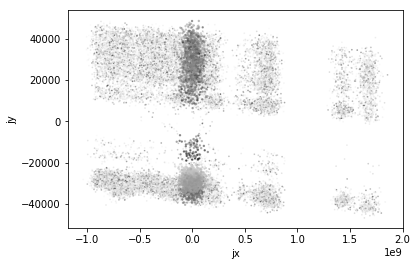

In [206]:
%matplotlib inline
dns_plot['jx'] = jitter(dns_plot['x'])
dns_plot['jy'] = jitter(dns_plot['y'])
# Now use dataframe group by cluster
cluster_groups = dns_plot.groupby('train')
# Plot the Machine Learning results
size = {0:0.5, 1:2, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=size[key], 
               color=dns_plot[dns_plot['train'] == key]['value'])

##### KIBANA Virtualization

In [214]:
index_name_dns = 'test'

from elasticsearch import Elasticsearch

es.indices.delete(index=index_name_dns, ignore=[400, 404])


print("REMOVING PAST DATA...")
print("COMPLETED")

REMOVING PAST DATA...
COMPLETED


In [233]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

dns_plot.reset_index()
dns_iter = dns_plot.iterrows()
index, document = next(dns_iter)
ids = np.arange(0, dns_plot.size, dtype='int32')

myId = pd.Series(ids)

newId = 3 * myId

new_df = pd.DataFrame(newId, columns = ['hi'])


dns_plot['id'] = myId
new_df['id'] = myId
dns_plot.head()
new_df.head()

,hi,id
0,0,0
1,3,1
2,6,2
3,9,3
4,12,4


In [225]:
# use_these_keys = ['x', 'y', 'value', 'train', 'jx', 'jy']
use_these_keys = ['hi']

def filterKeys(document):
    return {key: document[key] for key in use_these_keys }

In [226]:
def doc_generator(df):
    dns_iter = df.iterrows()
    for index, document in dns_iter:
        yield {
                "_index": index_name_dns,
                "_type": "dns_doc",
                "_id" : f"{document['id']}"0,
                "_source": filterKeys(document),
            }
    raise StopIteration

In [234]:
helpers.bulk(es, doc_generator(new_df))

SerializationError: ({'hi': 0}, TypeError("Unable to serialize 0 (type: <class 'numpy.int32'>)"))

In [44]:
print('METRICS')
print('*******')

asum = dns_plot[dns_plot['train'] == 0]['value'].sum()
anavg = asum/dns_plot[dns_plot['train'] == 0]['value'].size
summary = dns_plot[dns_plot['train'] == 0]['value'].describe()

print("Sum of Previous Data: {}".format(asum))
print("Average of Previous Data: {}".format(anavg))
print(summary)

METRICS
*******
Sum of Previous Data: 546.857312696817
Average of Previous Data: 0.02634948986686022
count    20754.000000
mean         0.026349
std          0.011798
min          0.000012
25%          0.017922
50%          0.027879
75%          0.035894
max          0.086899
Name: value, dtype: float64


In [147]:
from scipy import stats

t2, p2 = stats.ttest_ind(dns_testVal,dns_trainVal)
print("t-value:{}".format(t2))
print("p-value: {}".format(p2))

t-value:35.28915531478427
p-value: 4.6978225718992785e-266


##### CONN Data

In [152]:
conn_cols = list(conn_df.columns)
CdroppedList = []


print("TRAINING DATA")
print("************")
print("COLUMNS CHECKED:", end = " ") 

for columnC in conn_cols:
    if conn_df[columnC].isna().all():
        CdroppedList.append(columnC)
    else:
        if list(conn_df[columnC].isna())[0]:
            conn_df.loc[:,columnC].fillna(method='bfill', inplace=True)
        else:
            conn_df.loc[:,columnC].fillna(method='pad', inplace=True)
        print(columnC + ",", end = " ")

conn_df.drop(CdroppedList, axis=1, inplace= True)
conn_df.head()

TRAINING DATA
************
COLUMNS CHECKED: AA, RA, RD, TC, TTLs, answers, bro_timestamp, conn_state, duration, guid, history, host, ip_dst_addr, ip_dst_port, ip_src_addr, ip_src_port, local_orig, local_resp, method, missed_bytes, orig_bytes, orig_ip_bytes, orig_pkts, original_string, proto, protocol, qclass_name, qtype_name, query, rcode_name, rejected, resp_bytes, resp_fuids, resp_ip_bytes, resp_mime_types, resp_pkts, service, source:type, status_msg, tags, timestamp, tunnel_parents, uid, uri, user_agent, 

,AA,RA,RD,TC,TTLs,answers,bro_timestamp,conn_state,duration,guid,...,resp_pkts,service,source:type,status_msg,tags,timestamp,tunnel_parents,uid,uri,user_agent
1,2,2,2,1,4145,3438,1.561144e+09,10,6786,55852,...,2,6,0,14,1,1.561144e+12,0,22591,497,62
3,2,2,2,1,4145,3438,1.561144e+09,6,11153,49801,...,0,2,0,14,1,1.561144e+12,0,32668,497,62
6,2,2,2,1,4145,3438,1.561144e+09,6,9429,84050,...,0,2,0,14,1,1.561144e+12,0,28773,497,62
9,2,2,2,1,4145,3438,1.561144e+09,6,10854,51849,...,0,2,0,14,1,1.561144e+12,0,9178,497,62
11,2,2,2,1,4145,3438,1.561144e+09,6,12038,58547,...,0,2,0,14,1,1.561144e+12,0,17480,497,62


In [153]:
conn_colsT = list(conn_dfT.columns)
droppedListCT = []

print("TESTING DATA")
print("************")
print("COLUMNS CHECKED:", end = " ") 

for columnCT in conn_colsT:
    if conn_dfT[columnCT].isna().all():
        droppedListCT.append(columnCT)
    else:
        if list(conn_dfT[columnCT].isna())[0]:
            conn_dfT.loc[:,columnCT].fillna(method='bfill', inplace=True)
        else:
            conn_dfT.loc[:,columnCT].fillna(method='pad', inplace=True)
        print(columnCT + ",", end = " ")
        

conn_dfT.drop(droppedListCT, axis=1, inplace=True)
conn_dfT.head()

TESTING DATA
************
COLUMNS CHECKED: AA, RA, RD, TC, TTLs, answers, bro_timestamp, conn_state, duration, guid, history, host, ip_dst_addr, ip_dst_port, ip_src_addr, ip_src_port, local_orig, local_resp, method, missed_bytes, orig_bytes, orig_ip_bytes, orig_pkts, original_string, proto, protocol, qclass_name, qtype_name, query, rcode_name, rejected, resp_bytes, resp_fuids, resp_ip_bytes, resp_mime_types, resp_pkts, service, source:type, status_msg, tags, timestamp, tunnel_parents, uid, uri, user_agent, 

,AA,RA,RD,TC,TTLs,answers,bro_timestamp,conn_state,duration,guid,...,resp_pkts,service,source:type,status_msg,tags,timestamp,tunnel_parents,uid,uri,user_agent
4,2,2,2,1,181,149,1.563775e+09,3,0.410247,3155,...,0.0,1,0,3,1,1.563775e+12,0,497,24,5
5,2,2,2,1,181,149,1.563775e+09,6,15.031216,2146,...,6.0,3,0,3,1,1.563775e+12,0,1409,24,5
8,2,2,2,1,181,149,1.563775e+09,6,15.030331,1878,...,8.0,3,0,3,1,1.563775e+12,0,544,24,5
9,2,2,2,1,181,149,1.563775e+09,6,0.062993,1674,...,1.0,3,0,3,1,1.563775e+12,0,1136,24,5
20,2,2,2,1,181,149,1.563775e+09,3,0.429023,2544,...,0.0,1,0,3,1,1.563775e+12,0,25,24,5


In [154]:
conn_cols = list(conn_df.columns)
conn_colsT = list(conn_dfT.columns)
toDropC = []
toDropCT = []

for columnC in conn_cols:
    if columnC not in conn_colsT:
        toDropC.append(columnC)

for columnCT in conn_colsT:
    if columnCT not in conn_cols:
        toDropCT.append(columnCT)
print(toDropC)

conn_df.drop(toDropC, axis=1, inplace=True)
conn_dfT.drop(toDropCT, axis=1, inplace=True)      

[]


##### Creating Isolation Forest Model

In [155]:
conn_train, conn_valid = train_test_split(conn_df, test_size = 0.35)

In [156]:
conn_iforest = IsolationForest(n_estimators = 5, max_samples = 32220, contamination='auto', behaviour="new")
conn_iforest.fit(conn_train)

C:\Users\Intern Laptop\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:250: UserWarning: max_samples (32220) is greater than the total number of samples (25250). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
        max_features=1.0, max_samples=32220, n_estimators=5, n_jobs=None,
        random_state=None, verbose=0)

In [157]:
conn_iforest_pred_train = conn_iforest.predict(conn_valid)
conn_iforest_pred_test = conn_iforest.predict(conn_dfT)

conn_iforest_plot_values = conn_iforest.decision_function(conn_valid)
conn_iforest_plotT_values = conn_iforest.decision_function(conn_dfT)

conn_plot_values.append(abs(conn_iforest_plot_values))
conn_plotT_values.append(abs(conn_iforest_plotT_values))

##### Visualizing Isolation Forest Model

In [158]:
conn_iforest_pca = PCA(n_components=2).fit_transform(conn_valid)
conn_iforest_pcaT = PCA(n_components=2).fit_transform(conn_dfT)

conn_iforest_plot_df = pd.DataFrame()
conn_iforest_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
conn_iforest_plot_df['x'] = conn_iforest_pca[:, 0] # PCA X Column
conn_iforest_plot_df['y'] = conn_iforest_pca[:, 1] # PCA Y Column
conn_iforest_plot_df['value'] = conn_iforest_plot_values
conn_iforest_plot_df['train'] = 0


conn_iforest_plot_dfT['x'] = conn_iforest_pcaT[:, 0] # PCA X Column
conn_iforest_plot_dfT['y'] = conn_iforest_pcaT[:, 1] # PCA Y Column
conn_iforest_plot_dfT['value'] = conn_iforest_plotT_values
conn_iforest_plot_dfT['train'] = 1

conn_iforest_plot = pd.concat([conn_iforest_plot_df, conn_iforest_plot_dfT])

conn_iforest_plot.head()

,x,y,value,train
0,4.717267e+07,1528.505631,0.104089,0
1,-1.102606e+08,-39606.871225,0.040876,0
2,3.122207e+08,-27715.450845,0.106280,0
3,3.137129e+08,27309.507864,-0.030482,0
4,-2.990065e+08,-34827.682384,0.057375,0


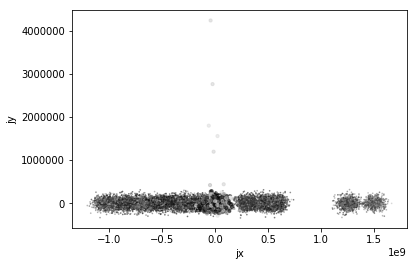

In [159]:
%matplotlib inline
conn_iforest_plot['jx'] = jitter(conn_iforest_plot['x'])
conn_iforest_plot['jy'] = jitter(conn_iforest_plot['y'])
# Now use dataframe group by cluster
iforest_cluster_groups = conn_iforest_plot.groupby('train')
# Plot the Machine Learning results
iforest_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in iforest_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=iforest_size[key], 
               color=conn_iforest_plot[conn_iforest_plot['train'] == key]['value'])

##### Creating CBLOF Model

In [160]:
conn_cblof = CBLOF(contamination=0.3)
conn_cblof.fit(conn_train)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.3, n_clusters=8, n_jobs=1, random_state=None,
   use_weights=False)

In [164]:
conn_cblof_pred_train = conn_cblof.predict(conn_valid)
conn_cblof_pred_test = conn_cblof.predict(conn_dfT)

conn_cblof_plot_values = conn_cblof.decision_function(conn_valid)
conn_cblof_plotT_values = conn_cblof.decision_function(conn_dfT)

conn_plot_values.append(conn_cblof_plot_values / 100000000)
conn_plotT_values.append(conn_cblof_plotT_values / 100000000)

##### Visualizing CBLOF  Model

In [165]:
conn_cblof_pca = PCA(n_components=2).fit_transform(conn_valid)
conn_cblof_pcaT = PCA(n_components=2).fit_transform(conn_dfT)

conn_cblof_plot_df = pd.DataFrame()
conn_cblof_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
conn_cblof_plot_df['x'] = conn_cblof_pca[:, 0] # PCA X Column
conn_cblof_plot_df['y'] = conn_cblof_pca[:, 1] # PCA Y Column
conn_cblof_plot_df['value'] = conn_cblof_plot_values / 10000000
conn_cblof_plot_df['train'] = 0


conn_cblof_plot_dfT['x'] = conn_cblof_pcaT[:, 0] # PCA X Column
conn_cblof_plot_dfT['y'] = conn_cblof_pcaT[:, 1] # PCA Y Column
conn_cblof_plot_dfT['value'] = conn_cblof_plotT_values / 10000000
conn_cblof_plot_dfT['train'] = 1

conn_cblof_plot = pd.concat([conn_cblof_plot_df, conn_cblof_plot_dfT])

conn_cblof_plot.head()

,x,y,value,train
0,4.717267e+07,1528.505631,48.327806,0
1,-1.102606e+08,-39606.871225,64.071136,0
2,3.122207e+08,-27715.450845,21.823000,0
3,3.137129e+08,27309.507864,21.673785,0
4,-2.990065e+08,-34827.682384,82.945719,0


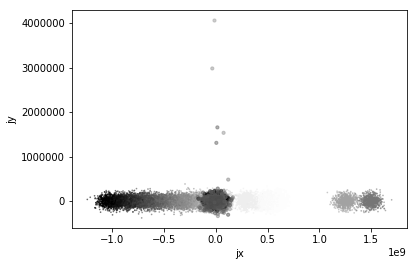

In [166]:
%matplotlib inline
conn_cblof_plot['jx'] = jitter(conn_cblof_plot['x'])
conn_cblof_plot['jy'] = jitter(conn_cblof_plot['y'])
# Now use dataframe group by cluster
cblof_cluster_groups = conn_cblof_plot.groupby('train')
# Plot the Machine Learning results
cblof_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in cblof_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=cblof_size[key], 
               color=conn_cblof_plot[conn_cblof_plot['train'] == key]['value'] * 1000)

##### HBOS Model

In [167]:
from pyod.models.hbos import HBOS
conn_hbos = HBOS(contamination=0.3)
conn_hbos.fit(conn_train)

HBOS(alpha=0.1, contamination=0.3, n_bins=10, tol=0.5)

In [171]:
conn_hbos_pred_train = conn_hbos.predict(conn_valid)
conn_hbos_pred_test = conn_hbos.predict(conn_dfT)

conn_hbos_plot_values = conn_hbos.decision_function(conn_valid)
conn_hbos_plotT_values = conn_hbos.decision_function(conn_dfT)

conn_plot_values.append(conn_hbos_plot_values / 10000)
conn_plotT_values.append(conn_hbos_plotT_values / 10000)

##### Visualizing HBOS Model

In [172]:
conn_hbos_pca = PCA(n_components=2).fit_transform(conn_valid)
conn_hbos_pcaT = PCA(n_components=2).fit_transform(conn_dfT)

conn_hbos_plot_df = pd.DataFrame()
conn_hbos_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
conn_hbos_plot_df['x'] = conn_hbos_pca[:, 0] # PCA X Column
conn_hbos_plot_df['y'] = conn_hbos_pca[:, 1] # PCA Y Column
conn_hbos_plot_df['value'] = conn_hbos_plot_values / 100
conn_hbos_plot_df['train'] = 0


conn_hbos_plot_dfT['x'] = conn_hbos_pcaT[:, 0] # PCA X Column
conn_hbos_plot_dfT['y'] = conn_hbos_pcaT[:, 1] # PCA Y Column
conn_hbos_plot_dfT['value'] = conn_hbos_plotT_values / 100
conn_hbos_plot_dfT['train'] = 1

conn_hbos_plot = pd.concat([conn_hbos_plot_df, conn_hbos_plot_dfT])

conn_hbos_plot.head()

,x,y,value,train
0,4.717267e+07,1528.505631,1.251095,0
1,-1.102606e+08,-39606.871225,1.274546,0
2,3.122207e+08,-27715.450845,1.250996,0
3,3.137129e+08,27309.507864,1.280539,0
4,-2.990065e+08,-34827.682384,1.251149,0


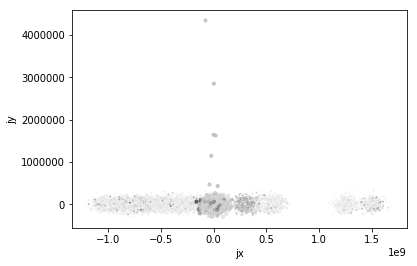

In [173]:
%matplotlib inline
conn_hbos_plot['jx'] = jitter(conn_hbos_plot['x'])
conn_hbos_plot['jy'] = jitter(conn_hbos_plot['y'])
# Now use dataframe group by cluster
hbos_cluster_groups = conn_hbos_plot.groupby('train')
# Plot the Machine Learning results
hbos_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in hbos_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=hbos_size[key], 
               color=conn_hbos_plot[conn_hbos_plot['train'] == key]['value'] * 1000)

##### COMBINING MODELS (DEMOCRATIC VOTING)

In [175]:
counterC = 0
counterCT = 0
conn_testVal = []
conn_trainVal = []
prevVal = []

print("COMPILING VOTES")
print("***************")

print("Training Data:", end=" ")
lablesC = {0: "Isolation Forest", 1:"CBLOF",2:"HBOS" }

for x in range(3):
    print(lablesC[x], end = ", ")


for valueC in conn_plot_values:
    
    if counterC == 0:
        for aValC in valueC:
            conn_trainVal.append(aValC)
    else:
        for xC in range(valueC.size):
            oldValueC = conn_trainVal[xC]
            newValueC = oldValueC + valueC[xC]
            conn_trainVal[xC] = newValueC
        
    counterC += 1
    
for wC in range(len(conn_trainVal)):
    oldValC = conn_trainVal[wC]
    newValC = oldValC / counterC
    conn_trainVal[wC] = newValC
        

print("\nTesting Data:", end=" ")

for valueCT in conn_plotT_values:
    
    if counterCT == 0:
        for aValCT in valueCT:
            conn_testVal.append(aValCT)
    else:
        for xCT in range(valueCT.size):
            oldValueCT = conn_testVal[xCT]
            newValueCT = oldValueCT + valueCT[xCT]
            conn_testVal[xCT] = newValueCT
        
    counterCT += 1
    
for wCT in range(len(conn_testVal)):
    oldValCT = conn_testVal[wCT]
    newValCT = oldValCT / counterCT
    conn_testVal[wCT] = newValCT

    
for xC in range(3):
    print(lables[xC], end = ", ")


COMPILING VOTES
***************
Training Data: Isolation Forest, CBLOF, HBOS, 
Testing Data: Isolation Forest, CBLOF, HBOS, 

In [176]:
conn_pca = PCA(n_components=2).fit_transform(conn_valid)
conn_pcaT = PCA(n_components=2).fit_transform(conn_dfT)

conn_plot_df = pd.DataFrame()
conn_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
conn_plot_df['x'] = conn_pca[:, 0] # PCA X Column
conn_plot_df['y'] = conn_pca[:, 1] # PCA Y Column
conn_plot_df['value'] = conn_trainVal  
conn_plot_df['train'] = 0


conn_plot_dfT['x'] = conn_pcaT[:, 0] # PCA X Column
conn_plot_dfT['y'] = conn_pcaT[:, 1] # PCA Y Column
conn_plot_dfT['value'] = conn_testVal[:conn_pcaT[:, 0].size]
conn_plot_dfT['train'] = 1

conn_plot = pd.concat([conn_plot_df, conn_plot_dfT])

conn_plot.head()

,x,y,value,train
0,4.717267e+07,1528.505631,10.680459,0
1,-1.102606e+08,-39606.871225,14.131865,0
2,3.122207e+08,-27715.450845,4.849838,0
3,3.137129e+08,27309.507864,4.802501,0
4,-2.990065e+08,-34827.682384,18.287059,0


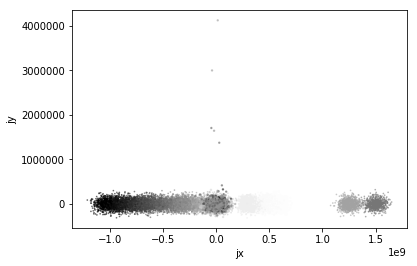

In [177]:
%matplotlib inline
conn_plot['jx'] = jitter(conn_plot['x'])
conn_plot['jy'] = jitter(conn_plot['y'])
# Now use dataframe group by cluster
cluster_groups = conn_plot.groupby('train')
# Plot the Machine Learning results
size = {0:0.5, 1:2, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=size[key], 
               color=conn_plot[conn_plot['train'] == key]['value'])

##### KIBANA Virtualization

In [180]:
index_name_conn = 'conn_visualization'

from elasticsearch import Elasticsearch

es.indices.delete(index=index_name_conn, ignore=[400, 404])


print("REMOVING PAST DATA...")
print("COMPLETED")

REMOVING PAST DATA...
COMPLETED


In [181]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

conn_plot.reset_index()
conn_iter = conn_plot.iterrows()
index, document = next(conn_iter)
conn_ids = np.arange(0, conn_plot.size, dtype='int32')

connId = pd.Series(conn_ids)

conn_plot['id'] = connId
conn_plot.head()

,x,y,value,train,jx,jy,id
0,4.717267e+07,1528.505631,10.680459,0,-4.331178e+07,-118736.783358,0
1,-1.102606e+08,-39606.871225,14.131865,0,-5.555160e+07,-162240.268653,1
2,3.122207e+08,-27715.450845,4.849838,0,4.671666e+08,-28261.779548,2
3,3.137129e+08,27309.507864,4.802501,0,3.215299e+08,-52324.420046,3
4,-2.990065e+08,-34827.682384,18.287059,0,-3.103079e+08,-82766.250985,4


In [182]:
use_these_keys = ['x', 'y', 'value', 'train', 'jx', 'jy']

def filterKeys(document):
    return {key: document[key] for key in use_these_keys }

In [183]:
def doc_generator(df):
    conn_iter = df.iterrows()
    for index, document in conn_iter:
        yield {
                "_index": index_name_conn,
                "_type": "conn_doc",
                "_id" : f"{document['id']}",
                "_source": filterKeys(document),
            }
    raise StopIteration

In [184]:
helpers.bulk(es, doc_generator(conn_plot))

RuntimeError: generator raised StopIteration

In [185]:
print('METRICS')
print('*******')

asum = conn_plot[conn_plot['train'] == 0]['value'].sum()
anavg = asum/conn_plot[conn_plot['train'] == 0]['value'].size
summary = conn_plot[conn_plot['train'] == 0]['value'].describe()

print("Sum of Previous Data: {}".format(asum))
print("Average of Previous Data: {}".format(anavg))
print(summary)

METRICS
*******
Sum of Previous Data: 220722.53803302144
Average of Previous Data: 16.23317923314124
count    13597.000000
mean        16.233179
std         10.607724
min          0.039129
25%          4.891222
50%         16.121245
75%         25.121055
max         34.729781
Name: value, dtype: float64


In [186]:
from scipy import stats

tC2, pC2 = stats.ttest_ind(conn_testVal,conn_trainVal)
print("t-value:{}".format(tC2))
print("p-value: {}".format(pC2))

t-value:74.72368453821588
p-value: 0.0


In [ ]:
http_cols = list(http_df.columns)
HdroppedList = []


print("TRAINING DATA")
print("************")
print("COLUMNS CHECKED:", end = " ") 

for columnH in http_cols:
    if http_df[columnH].isna().all():
        HdroppedList.append(columnH)
    else:
        if list(http_df[columnH].isna())[0]:
            http_df.loc[:,columnH].fillna(method='bfill', inplace=True)
        else:
            http_df.loc[:,columnH].fillna(method='pad', inplace=True)
        print(columnH + ",", end = " ")

http_df.drop(CdroppedList, axis=1, inplace= True)
http_df.head()